In [2]:
from importlib import reload
from model import *
from train import *
from dataloader import *
import dataloader as _D
reload(_D)
import utils as _U
reload(_U)
from collections import OrderedDict
import yaml

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training Settings

In [3]:
with open('configs/I20R5/I20R5_09-11.yml', 'r') as f:
    setting = _U.Dict2ObjParser(yaml.safe_load(f)).parse()

In [4]:
if 'models' not in os.listdir('./'):
    os.system('mkdir models')
if setting.TRAIN.MODEL_SAVE_FILE.split('/')[1] not in os.listdir('./models/'):
    os.system(f"cd models && mkdir {setting.TRAIN.MODEL_SAVE_FILE.split('/')[1]}")
if 'logs' not in os.listdir('./'):
    os.system('mkdir logs')
if setting.TRAIN.LOG_SAVE_FILE.split('/')[1] not in os.listdir('./logs/'):
    os.system(f"cd logs && mkdir {setting.TRAIN.LOG_SAVE_FILE.split('/')[1]}")

## Train & Valid

### Dataset Preparation

In [4]:
train_dataset = _D.ImageDataSet(win_size = setting.DATASET.LOOKBACK_WIN, \
                            start_date = setting.DATASET.START_DATE, \
                            end_date = setting.DATASET.END_DATE, \
                            mode = setting.DATASET.MODE, \
                            indicators = setting.DATASET.INDICATORS, \
                            show_volume = setting.DATASET.SHOW_VOLUME, \
                            parallel_num=setting.DATASET.PARALLEL_NUM)

[Load Data] | 2023-04-20 04:01:34 Done | Using  7.530 seconds
DataSet Initialized
 	 - Mode:         DEFAULT
 	 - Image Size:   (64, 60)
 	 - Time Period:  20091231 - 20111231
 	 - Indicators:   [('MA', ['20'])]
 	 - Volume Shown: True


In [5]:
image_set = train_dataset.generate_images(setting.DATASET.SAMPLE_RATE)

Generating Images (sample rate: 0.2): 100%|██████████| 2283/2283 [15:58<00:00,  2.38it/s]


In [6]:
len(image_set)

176083

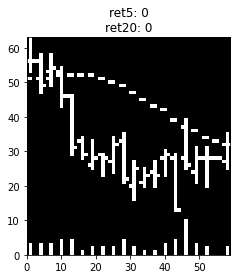

In [7]:
# preview of the "image" (np.array)
display_image(image_set[69])

In [8]:
train_loader_size = int(len(image_set)*(1-setting.TRAIN.VALID_RATIO))
valid_loader_size = len(image_set) - train_loader_size

train_loader, valid_loader = torch.utils.data.random_split(image_set, [train_loader_size, valid_loader_size])
train_loader = torch.utils.data.DataLoader(dataset=train_loader, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_loader, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=True)

### Model Structure

In [9]:
model_d20 = CNN20d()
model_d20.to(device)

CNN20d(
  (conv1): Sequential(
    (Conv): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(3, 1), dilation=(2, 1))
    (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (Conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(3, 1))
    (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (Conv): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (DropOut): Dropout(p=0.5

### Training Process

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_d20.parameters(), lr=setting.TRAIN.LEARNING_RATE, weight_decay=setting.TRAIN.WEIGHT_DECAY)

In [11]:
train_loss_set, valid_loss_set, train_acc_set, valid_acc_set = train_n_epochs(setting.TRAIN.NEPOCH, model_d20, setting.TRAIN.LABEL, train_loader, valid_loader, criterion, optimizer, setting.TRAIN.MODEL_SAVE_FILE, setting.TRAIN.EARLY_STOP_EPOCH)

Epoch: 1 Training Loss: 1.036574 Validation Loss: 0.725793 Training Acc: 0.51146 Validation Acc: 0.54264
Validation loss decreased (inf --> 0.725793).  Saving model ...
Epoch: 2 Training Loss: 0.955404 Validation Loss: 0.708836 Training Acc: 0.52468 Validation Acc: 0.55565
Validation loss decreased (0.725793 --> 0.708836).  Saving model ...
Epoch: 3 Training Loss: 0.902153 Validation Loss: 0.699022 Training Acc: 0.53001 Validation Acc: 0.56119
Validation loss decreased (0.708836 --> 0.699022).  Saving model ...
Epoch: 4 Training Loss: 0.858724 Validation Loss: 0.691440 Training Acc: 0.53833 Validation Acc: 0.56318
Validation loss decreased (0.699022 --> 0.691440).  Saving model ...
Epoch: 5 Training Loss: 0.828780 Validation Loss: 0.691435 Training Acc: 0.54060 Validation Acc: 0.56475
Validation loss decreased (0.691440 --> 0.691435).  Saving model ...
Epoch: 6 Training Loss: 0.803340 Validation Loss: 0.683719 Training Acc: 0.54440 Validation Acc: 0.56750
Validation loss decreased (0.6

In [ ]:
plot_loss_and_acc({"temp train": [train_loss_set, train_acc_set], \
                    "temp valid": [valid_loss_set, valid_acc_set]})

In [13]:
log = pd.DataFrame([train_loss_set, train_acc_set, valid_loss_set, valid_acc_set], index=['train_loss', 'train_acc', 'valid_loss', 'valid_acc'])
log.to_csv(setting.TRAIN.LOG_SAVE_FILE)

In [14]:
logs = pd.read_csv(setting.TRAIN.LOG_SAVE_FILE, index_col=0).T

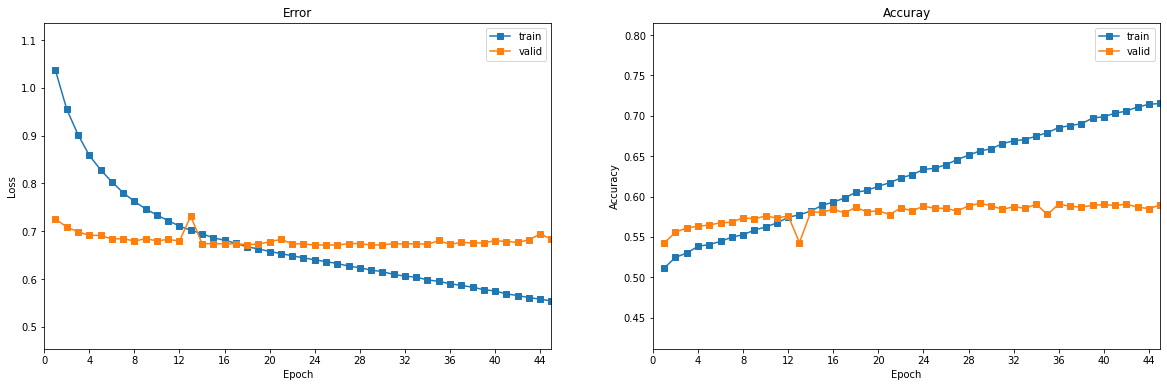

: 

In [15]:
plot_loss_and_acc({"train": [logs['train_loss'], logs['train_acc']], \
                    "valid": [logs['valid_loss'], logs['valid_acc']]})

## Test

### Dataset Preparation

In [5]:
test_dataset = _D.ImageDataSet(win_size = setting.DATASET.LOOKBACK_WIN, \
                            start_date = setting.TEST.START_DATE, \
                            end_date = setting.TEST.END_DATE, \
                            mode = setting.DATASET.MODE, \
                            indicators = setting.DATASET.INDICATORS, \
                            show_volume = setting.DATASET.SHOW_VOLUME, \
                            parallel_num=setting.DATASET.PARALLEL_NUM)

[Load Data] | 2023-04-20 07:21:33 Done | Using  8.754 seconds
DataSet Initialized
 	 - Mode:         DEFAULT
 	 - Image Size:   (64, 60)
 	 - Time Period:  20111231 - 20121231
 	 - Indicators:   [('MA', ['20'])]
 	 - Volume Shown: True


In [6]:
test_imageset = test_dataset.generate_images(setting.TEST.SAMPLE_RATE)

Generating Images (sample rate: 0.2): 100%|██████████| 2458/2458 [10:38<00:00,  3.85it/s]


In [7]:
len(test_imageset)

111311

In [12]:
test_loader = torch.utils.data.DataLoader(dataset=test_imageset, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=False)

### Load Model

In [8]:
model_best =  CNN20d()
model_best.to(device)

CNN20d(
  (conv1): Sequential(
    (Conv): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(3, 1), dilation=(2, 1))
    (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (Conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(3, 1))
    (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (Conv): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (DropOut): Dropout(p=0.5

In [9]:
state_dict = torch.load(setting.TRAIN.MODEL_SAVE_FILE)
model_best.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [10]:
def model_test(model, label_type, classes, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = [0., 0.]
    class_total = [0., 0.]

    model.eval()
    # iterate over test data
    for i, (data, ret5, ret20) in enumerate(test_loader):
        assert label_type in ['RET5', 'RET20'], f"Wrong Label Type: {label_type}"
        if label_type == 'RET5':
            target = ret5
        else:
            target = ret20
            
        target = (1-target).unsqueeze(1) @ torch.LongTensor([1., 0.]).unsqueeze(1).T + target.unsqueeze(1) @ torch.LongTensor([0, 1]).unsqueeze(1).T
        target = target.to(torch.float32)
            
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        pred = torch.argmax(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(torch.argmax(target, 1).data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not device == 'cuda' else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(target.shape[0]):
            label = torch.argmax(target.data[i])
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(2):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [13]:
criterion = nn.BCELoss()
model_test(model_best, setting.TRAIN.LABEL, ['down', 'up'], test_loader, criterion)

Test Loss: 0.726079

Test Accuracy of  down: 60% (32924/54606)
Test Accuracy of    up: 42% (24312/56705)

Test Accuracy (Overall): 51% (57236/111311)
